This notebook is analysing for depth-averaged momentum budget terms in 1/8 deg OM4 simulation.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:35710' processes=4 threads=16, memory=406.01 GB>

In [3]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

$\Large \text{Daily-averaged Data}$

In [5]:
# Read monthly-averaged files
ppdir = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/"
ds = xr.open_mfdataset(ppdir + "*.nc")

ppdir1 = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/"
ds_grid = xr.open_dataset(ppdir1 + "ocean_monthly.static.nc")

ds = ds.assign_coords({'geolon': ds_grid['geolon'], 'geolat': ds_grid['geolat'], 
                      'geolon_u': ds_grid['geolon_u'], 'geolat_u': ds_grid['geolat_u'],
                      'geolon_v': ds_grid['geolon_v'], 'geolat_v': ds_grid['geolat_v'],
                      'geolon_c': ds_grid['geolon_c'], 'geolat_c': ds_grid['geolat_c']})

print(ds)

<xarray.Dataset>
Dimensions:           (nv: 2, time: 120, xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * nv                (nv) float64 1.0 2.0
  * time              (time) object 0001-01-16 12:00:00 ... 0010-12-16 12:00:00
  * xq                (xq) float64 -298.5 -298.4 -298.3 ... 61.12 61.23 61.35
  * yh                (yh) float64 -83.62 -83.58 -83.54 ... 89.86 89.92 89.97
  * xh                (xh) float64 -298.6 -298.5 -298.4 ... 61.05 61.16 61.28
  * yq                (yq) float64 -83.6 -83.56 -83.52 ... 89.89 89.95 90.0
    geolon            (yh, xh) float32 ...
    geolat            (yh, xh) float32 ...
    geolon_u          (yh, xq) float32 ...
    geolat_u          (yh, xq) float32 ...
    geolon_v          (yq, xh) float32 ...
    geolat_v          (yq, xh) float32 ...
    geolon_c          (yq, xq) float32 ...
    geolat_c          (yq, xq) float32 ...
Data variables:
    average_DT        (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    av

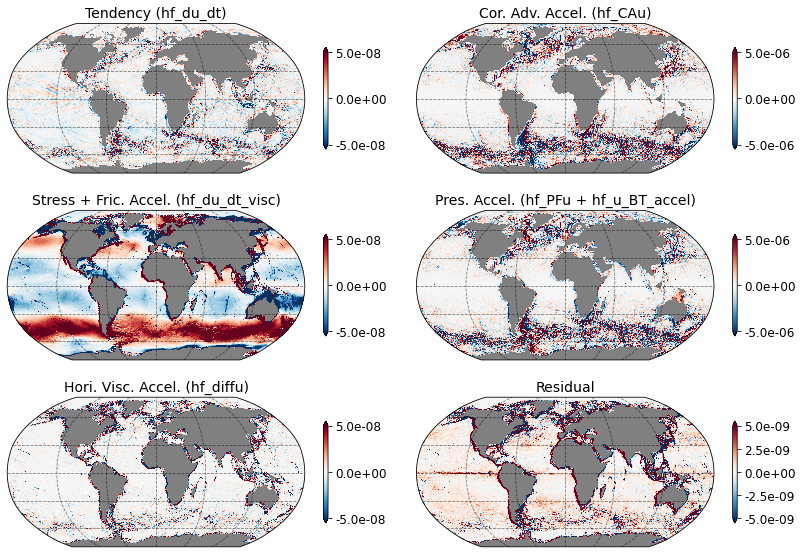

In [11]:
# Zonal Momentum budget
idx = 100
max_r = 0.5e-5

ds1 = ds.isel(time=idx)

grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[14,10])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_du_dt)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_CAu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAu)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_PFu_2d']+ds1['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel. (hf_PFu + hf_u_BT_accel)')
    
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_du_dt_visc_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_du_dt_visc)')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffu)')

tmp = ds1['hf_dudt_2d']-ds1['hf_CAu_2d']-ds1['hf_PFu_2d']-ds1['hf_diffu_2d']-ds1['hf_du_dt_visc_2d']-ds1['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[2, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-4*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Residual')

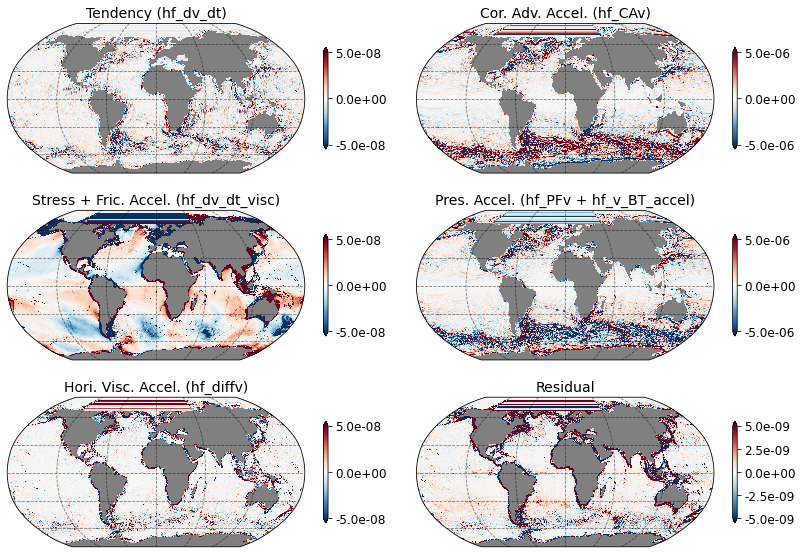

In [12]:
# Meridional Momentum budget
idx = 100
max_r = 0.5e-5

ds1 = ds.isel(time=idx)

grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[14,10])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_dvdt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Tendency (hf_dv_dt)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_CAv_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAv)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_PFv_2d']+ds1['hf_v_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Pres. Accel. (hf_PFv + hf_v_BT_accel)')
    
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_dv_dt_visc_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_dv_dt_visc)')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_diffv_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffv)')

tmp = ds1['hf_dvdt_2d']-ds1['hf_CAv_2d']-ds1['hf_PFv_2d']-ds1['hf_diffv_2d']-ds1['hf_dv_dt_visc_2d']-ds1['hf_v_BT_accel_2d']
ax = fig.add_subplot(grid[2, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-4*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Residual')

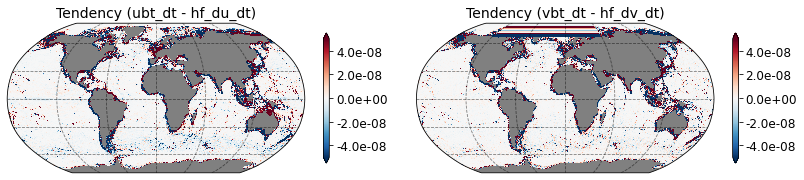

In [22]:
# Difference between barotropic tendency and depth-averaged tendency terms
idx = 100
max_r = 0.5e-5

ds1 = ds.isel(time=idx)

grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[14,4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['ubt_dt'] - ds1['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (ubt_dt - hf_du_dt)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['vbt_dt'] - ds1['hf_dvdt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='Tendency (vbt_dt - hf_dv_dt)')

In [10]:
ds1['hf_CAu_2d']
#ds.nbytes/1e9

<xarray.DataArray 'hf_CAu_2d' (yh: 2240, xq: 2880)>
dask.array<getitem, shape=(2240, 2880), dtype=float32, chunksize=(2240, 2880), chunktype=numpy.ndarray>
Coordinates:
    time      object 0009-05-16 12:00:00
  * xq        (xq) float64 -298.5 -298.4 -298.3 -298.2 ... 61.12 61.23 61.35
  * yh        (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.86 89.92 89.97
    geolon_u  (yh, xq) float32 ...
    geolat_u  (yh, xq) float32 ...
Attributes:
    long_name:      Depth-sum Fractional Thickness-weighted Zonal Coriolis an...
    units:          m s-2
    cell_methods:   yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

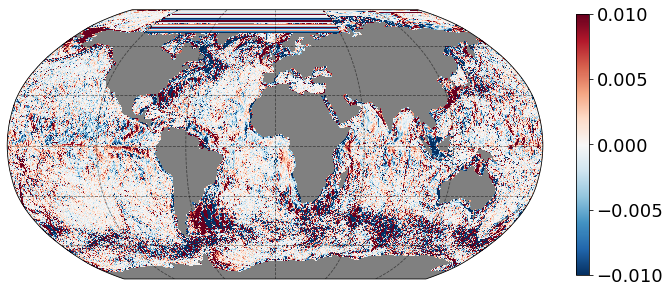

In [20]:
ds1 = ds.isel(time =50)

subplot_kws=dict(projection=ccrs.Robinson(),facecolor='grey')

plt.figure(figsize=[12,8])
p = ds1['tauy_bot'].plot(x='geolon_v', y='geolat_v', vmin=-1e-2, vmax=1e-2, cmap='RdBu_r',
                          subplot_kws=subplot_kws, transform=ccrs.PlateCarree(),
                          add_labels=False, add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, shrink=0.6)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

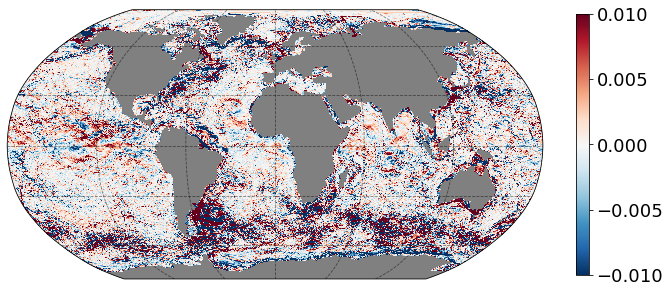

In [19]:
ds1 = ds.isel(time =100)

subplot_kws=dict(projection=ccrs.Robinson(),facecolor='grey')

plt.figure(figsize=[12,8])
p = ds1['taux_bot'].plot(x='geolon_u', y='geolat_u', vmin=-1e-2, vmax=1e-2, cmap='RdBu_r',
                          subplot_kws=subplot_kws, transform=ccrs.PlateCarree(),
                          add_labels=False, add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, shrink=0.6)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

$\Large \text{Daily-averaged Data}$

In [4]:
# Budgets in daily averaged data 

ppdir = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_daily/ts/daily/5yr/"
ds_daily = xr.open_mfdataset(ppdir + "ocean_daily.00060101-00101231*.nc")

ppdir1 = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_daily/"
ds_grid = xr.open_dataset(ppdir1 + "ocean_daily.static.nc")

ds_daily = ds_daily.assign_coords({'geolon': ds_grid['geolon'], 'geolat': ds_grid['geolat'], 
                      'geolon_u': ds_grid['geolon_u'], 'geolat_u': ds_grid['geolat_u'],
                      'geolon_v': ds_grid['geolon_v'], 'geolat_v': ds_grid['geolat_v'],
                      'geolon_c': ds_grid['geolon_c'], 'geolat_c': ds_grid['geolat_c']})

print(ds_daily)

<xarray.Dataset>
Dimensions:           (nv: 2, time: 1825, xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * nv                (nv) float64 1.0 2.0
  * time              (time) object 0006-01-01 12:00:00 ... 0010-12-31 12:00:00
  * xq                (xq) float64 -298.5 -298.4 -298.3 ... 61.12 61.23 61.35
  * yh                (yh) float64 -83.62 -83.58 -83.54 ... 89.86 89.92 89.97
  * xh                (xh) float64 -298.6 -298.5 -298.4 ... 61.05 61.16 61.28
  * yq                (yq) float64 -83.6 -83.56 -83.52 ... 89.89 89.95 90.0
    geolon            (yh, xh) float32 ...
    geolat            (yh, xh) float32 ...
    geolon_u          (yh, xq) float32 ...
    geolat_u          (yh, xq) float32 ...
    geolon_v          (yq, xh) float32 ...
    geolat_v          (yq, xh) float32 ...
    geolon_c          (yq, xq) float32 ...
    geolat_c          (yq, xq) float32 ...
Data variables:
    average_DT        (time) timedelta64[ns] dask.array<chunksize=(1825,), meta=np.ndarray>
   

In [25]:
ds['time'][100]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(9, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 0009-05-16 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [33]:
ds_daily['time'][1230]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(9, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 0009-05-16 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

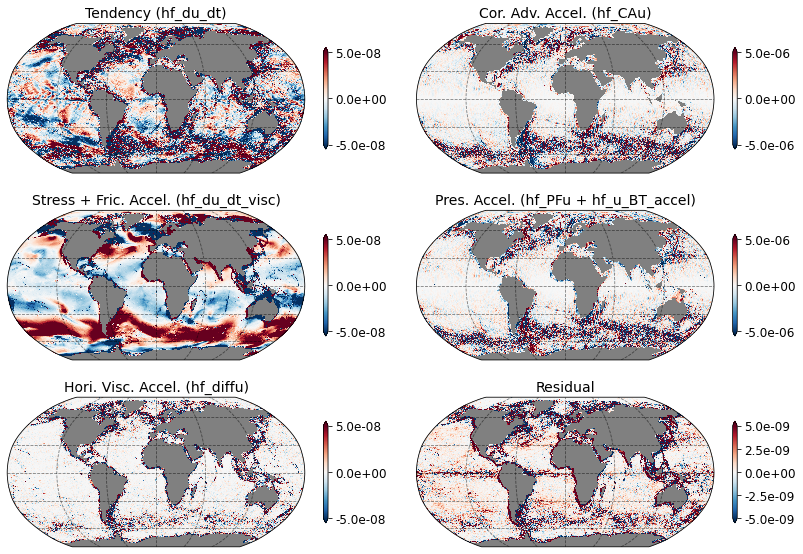

In [34]:
# Zonal Momentum budget
idx = 1230
max_r = 0.5e-5

ds1 = ds_daily.isel(time=idx)

grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[14,10])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_du_dt)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_CAu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAu)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_PFu_2d']+ds1['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel. (hf_PFu + hf_u_BT_accel)')
    
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_du_dt_visc_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_du_dt_visc)')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffu)')

tmp = ds1['hf_dudt_2d']-ds1['hf_CAu_2d']-ds1['hf_PFu_2d']-ds1['hf_diffu_2d']-ds1['hf_du_dt_visc_2d']-ds1['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[2, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-4*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Residual')

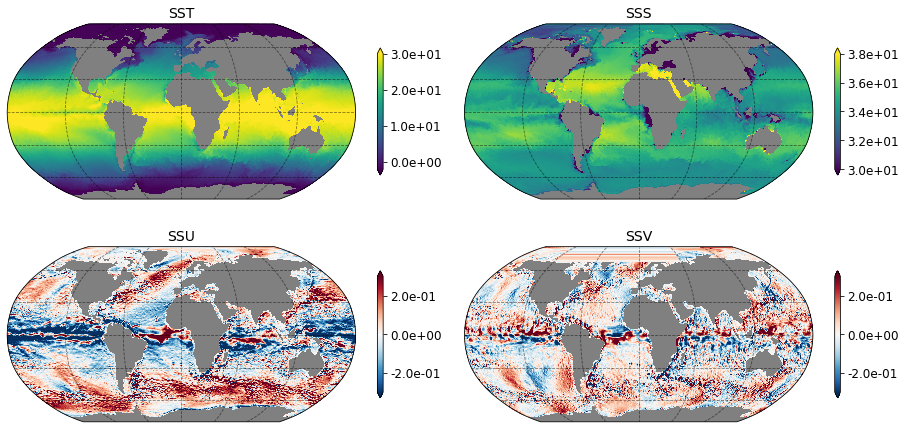

In [11]:
idx = 1200
max_r = 0.5

ds1 = ds_daily.isel(time=idx)

grid = plt.GridSpec(2, 2, wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=[16,8])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['tos'], vmin=-2., vmax=30., vstep=2.,
                   lon='geolon', lat='geolat', cmap='viridis', title='SST')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['sos'], vmin=30., vmax=38., vstep=1.0,
                   lon='geolon', lat='geolat', cmap='viridis', title='SSS')

max_r = 0.3
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['ssu'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='SSU')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds1['ssv'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='SSV')

In [12]:
#ds.close()
ds_daily.close()
client.close()
cluster.close()